## OpenCV Integration Example
Note: SwiftCV package requires OpenCV installed in order to compile.

In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/SwiftCV")' SwiftCV
%install '.package(path: "$cwd/FastaiNotebook_00_load_data")' FastaiNotebook_00_load_data

Installing packages:
	.package(path: "/home/jhoward/git/fastai_docs/dev_swift/SwiftCV")
		SwiftCV
	.package(path: "/home/jhoward/git/fastai_docs/dev_swift/FastaiNotebook_00_load_data")
		FastaiNotebook_00_load_data
With SwiftPM flags: []
Working in: /tmp/tmp9l41f1cf/swift-install
/home/jhoward/swift/usr/bin/swift-build: /home/jhoward/anaconda3/lib/libuuid.so.1: no version information available (required by /home/jhoward/swift/usr/lib/swift/linux/libFoundation.so)
/home/jhoward/swift/usr/bin/swift-build: /home/jhoward/anaconda3/lib/libcurl.so.4: no version information available (required by /home/jhoward/swift/usr/lib/swift/linux/libFoundation.so)
/home/jhoward/swift/usr/bin/swiftc: /home/jhoward/anaconda3/lib/libuuid.so.1: no version information available (required by /home/jhoward/swift/usr/bin/swiftc)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
/home/jhoward/swift/usr/bin/swiftc: /home/jhoward/anaconda3/lib/libuuid.so.1: no version information available (required by /

### Imports

In [ ]:
%include "EnableIPythonDisplay.swift"
import Foundation
import Python
import TensorFlow
import SwiftCV
import Path

let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [ ]:
import FastaiNotebook_00_load_data

In [ ]:
// display opencv version
print(cvVersion())

4.1.0


### Utility

In [ ]:
func show_img(_ img: Mat, _ w: Int = 7, _ h: Int = 5) {
    // convert from OpenCV to Tensor
    let tens = Tensor<UInt8>(cvMat: img)!
    // and from Tensor to numpy array for matplot
    show_img(tens.makeNumpyArray(), w, h)
}

func show_img(_ img: PythonObject, _ w: Int = 7, _ h: Int = 5) {
    plt.figure(figsize: [w, h])
    plt.imshow(img)
    plt.axis("off")
    plt.show()
}

### Load image

In [ ]:
let path = Path.cwd/"SwiftCV/Tests/SwiftCVTests/fixtures"

In [ ]:
func readImage(_ path:Path)->Mat {
    let cvImg = try! imdecode(Data(contentsOf: path.url))
    return cvtColor(cvImg, nil, ColorConversionCode.COLOR_BGR2RGB)
}

In [ ]:
import COpenCV

In [ ]:
func readImage2(_ data:Data)->SwiftCV.Mat {
    let cvImg = imdecode(data)
    return cvImg
//     return Mat_NewWithSize(10, 10, 1)
//     return cvtColor(cvImg, nil, ColorConversionCode.COLOR_BGR2RGB)
}

In [ ]:
let imgpath = Path("/home/jhoward/.fastai/data/imagenette/val/n03425413/ILSVRC2012_val_00017350.JPEG")!

In [ ]:
let data = Data(contentsOf: imgpath.url)

In [ ]:
var cvImg = readImage(imgpath)

In [ ]:
cvImg.size

▿ 2 elements
  - 0 : 500
  - 1 : 343


In [ ]:
time(repeating:10) {_ = readImage(imgpath)}

average: 7.809723 ms,   min: 7.724012 ms,   max: 8.221166 ms


In [ ]:
time(repeating:10) {_ = readImage2(data)}

average: 7.516784799999999 ms,   min: 7.505396 ms,   max: 7.52498 ms


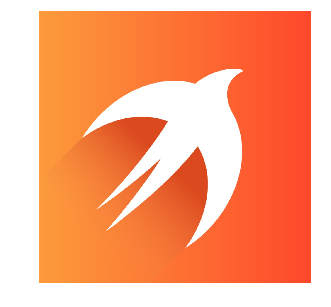

In [ ]:
show_img(cvImg)

In [ ]:
cvImg = resize(cvImg, nil, Size(512, 512), 0, 0, InterpolationFlag.INTER_AREA)

In [ ]:
time(repeating:10) {_ = resize(cvImg, nil, Size(512, 512), 0, 0, InterpolationFlag.INTER_AREA)}

average: 13.980540999999999 ms,   min: 13.959256 ms,   max: 14.037032 ms


In [ ]:
var imgs = [Mat]()
for i in (0..<10) {imgs.append(cvImg)}

In [ ]:
public protocol Countable {
    var count:Int {get}
}
extension Mat:Countable {}
extension Array:Countable {}

public extension Sequence where Element:Countable {
    public var totalCount:Int { return map({ $0.count }).reduce(0, +) }
}

In [ ]:
func f(_ imgs:[Mat])->Tensor<Float> {
    let c = imgs.totalCount
    let ptr = UnsafeMutableRawPointer.allocate(byteCount: c, alignment: 1)
    defer {ptr.deallocate()}
    var p = ptr
    for img in imgs {
        p.copyMemory(from: img.dataPtr, byteCount: img.count)
        p = p.advanced(by: img.count)
    }
    let r = UnsafeBufferPointer(start: ptr.bindMemory(to: UInt8.self, capacity: c), count: c)
    cvImg = imgs[0]
    let shape = TensorShape([imgs.count, cvImg.rows, cvImg.cols, cvImg.channels])
    let res = Tensor(shape: shape, scalars: r)
    return Tensor<Float>(res)/255.0
}

In [ ]:
var t = f(imgs)

In [ ]:
t.shape

▿ TensorShape
  ▿ dimensions : 4 elements
    - 0 : 10
    - 1 : 512
    - 2 : 512
    - 3 : 3


In [ ]:
time(repeating:10) {let te = f(imgs)}

average: 2.5188835000000003 ms,   min: 2.494807 ms,   max: 2.547066 ms


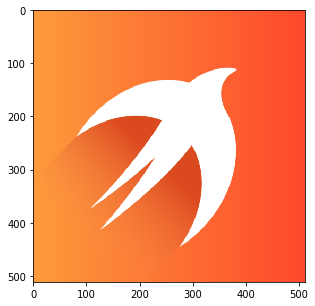

In [ ]:
show_img((t[0]).makeNumpyArray())

### OpenCV Transformations

#### Resize

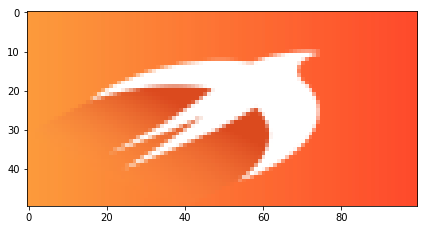

In [ ]:
show_img(
    resize(cvImg, nil, Size(100, 50), 0, 0, InterpolationFlag.INTER_AREA)
)

#### Zoom / Crop

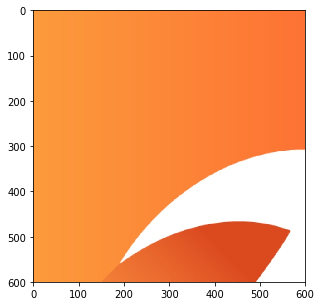

In [ ]:
let zoomMat = getRotationMatrix2D(Size(cvImg.cols, cvImg.rows / 2), 0, 1)
show_img(
    warpAffine(cvImg, nil, zoomMat, Size(600, 600))
)

#### Rotate

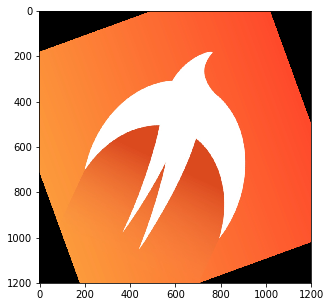

In [ ]:
let rotMat = getRotationMatrix2D(Size(cvImg.cols / 2, cvImg.rows / 2), 20, 1)
show_img(
    warpAffine(cvImg, nil, rotMat, Size(cvImg.cols, cvImg.rows))
)

#### Pad

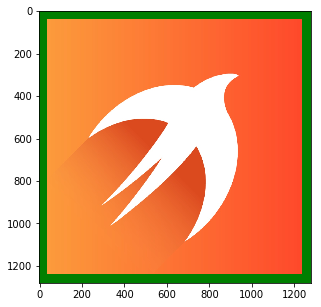

In [ ]:
show_img(
    copyMakeBorder(cvImg, nil, 40, 40, 40, 40, BorderType.BORDER_CONSTANT, RGBA(0, 127, 0, 0))
)

#### Blur

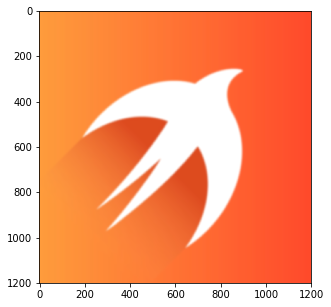

In [ ]:
show_img(
    GaussianBlur(cvImg, nil, Size(25, 25))
)

#### Flip

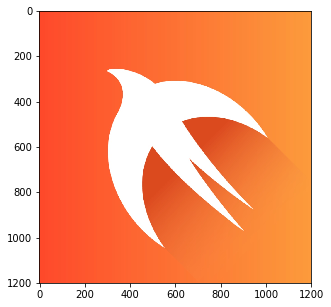

In [ ]:
show_img(
    flip(cvImg, nil, FlipMode.HORIZONTAL)
)

#### Transpose

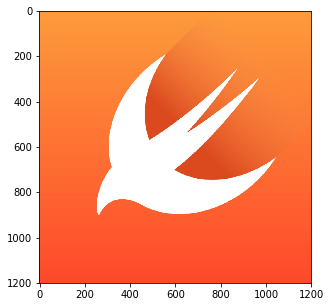

In [ ]:
show_img(
    transpose(cvImg, nil)
)

### Using Native S4TF Tensor Operations

#### Lightning / Contrast

In [ ]:
// convert image to floats Tensor
var imgTens = Tensor<Float>(Tensor<UInt8>(cvMat: cvImg)!) / 255
let contr:Float = 1.8
let lightn:Float = 0.2
let mean = imgTens.mean()
imgTens = (imgTens - mean) * contr + mean + lightn
show_img(imgTens.makeNumpyArray())

#### Noise

In [ ]:
// convert image to Tensor
let smallImg = resize(cvImg, nil, Size(150, 150))
var imgTens = Tensor<Float>(Tensor<UInt8>(cvMat: smallImg)!) / 255

// make white noise (slow! :))
var rng = PhiloxRandomNumberGenerator(seed: UInt64(42))
let dist = NormalDistribution<Float>(mean: 0, standardDeviation: 0.05)
var random: [Float] = []
for _ in 0..<imgTens.shape.contiguousSize {
    random.append(dist.next(using: &rng))
}
let randTens = Tensor<Float>(shape: imgTens.shape, scalars: random)

imgTens += randTens
show_img(imgTens.makeNumpyArray())